In [18]:
import networkx as nx
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, deque
#from cdlib.classes import NodeClustering

DEFAULT_DATA_FOLDER = "."
def draw_graph(G: nx.Graph, **kwargs):
    plt.title(G.name)
    nx.draw(G, with_labels=True, **kwargs)
    plt.show()

def read_with_clusters(path):
	G = nx.Graph()
	with open(path, 'r') as file:
		line = file.readline()
		n = int(line.strip().split(" ")[1])
		for i in range(n):
			parts = file.readline().strip().split(" ")
			id = int(parts[0])
			label = parts[1]
			cluster_id = int(parts[2])
			G.add_node(id, label=label, cluster=cluster_id)
		line = file.readline()
		m = int(line.strip().split(" ")[1])
		for _ in range(m):
			parts = file.readline().strip().split(" ")
			G.add_edge(int(parts[0]), int(parts[1]))
			
	return G

def distance(G, i):
	D = [-1] * len(G) # D = {}
	Q = deque()
	D[i] = 0
	Q.append(i)
	while Q:
		i = Q.popleft()
		for j in G[i]:
			if D[j] == -1: # if j not in D:
				D[j] = D[i] + 1
				Q.append(j)
	return [d for d in D if d > 0]

def distances(G, n = 100):
	D = []
	approx = G.nodes()
	if len(G) > n:
		approx = random.sample(list(G.nodes()), n)
	for i in approx:
		D.append(distance(G, i))
	return D

def lcc(G: nx.Graph) -> float:
    """relative size of the largest connected component (between 0 and 1)"""
    if G.is_directed(): G = nx.Graph(G)

    return len(max(nx.connected_components(G), key=len)) / len(G)

def distribution(G):
	degrees = np.array(sorted([G.degree(n) for n in G.nodes()], reverse=True))
	count_general = Counter(degrees)
	fig = plt.figure()
	plt.xscale("log")
	plt.yscale("log")
	general_dist = plt.scatter(count_general.keys(), count_general.values(), label="General degrees", s=20)
	plt.xlabel("k")
	plt.ylabel("p(k)")
	plt.legend()
	plt.title(G.name)
	plt.show()
	plt.savefig(f"{G.name}")

def info(G):
	print("{:>20s} | '{:s}'".format('Graph', G.name))
	n = G.number_of_nodes()
	print("{:>20s} | {:,d}".format('Nodes', n))
	m = G.number_of_edges()
	print("{:>20s} | {:,d}".format('Edges', m))
	k = 2*m/n
	print("{:>20s} | {:.2f}".format('Degree', k))
	max_degree = max([G.degree(n) for n in G.nodes()])
	print("{:>20s} | {:.2f}".format('Max node degree', max_degree))
	cc = lcc(G)
	print("{:>20s} | {:.2f}".format('LCC', cc))
	dis = [i for d in distances(G) for i in d]
	print("{:>20s} | {:.2f} ({:,d})".format('Distance', sum(dis) / len(dis), max(dis)))
	density = k/(n-1)
	print("{:>20s} | {:.9f}".format('Density', density))
	clustering = nx.average_clustering(G)
	print("{:>20s} | {:.9f}".format('Clustering', clustering))
	distribution(G)

def pagerank(G: nx.Graph, alpha=0.85, eps=1e-6, teleport: set | None = None):
    P = [1 / len(G)] * len(G)
    diff = 1
    while diff > eps:
        U = [sum([P[j] * alpha / G.degree(j) for j in G[i]])
             for i in G.nodes()]
        u = sum(U)
        if teleport is not None:
            for i in teleport:
                U[i] += (1 - u) / len(teleport)
        else:
            U = [U[i] + (1 - u) / len(G) for i in G.nodes()]
        diff = sum([abs(P[i] - U[i]) for i in G.nodes()])
        P = U
    return {i: P[i] for i in range(len(P))}

def find_node(G: nx.Graph, label: str):
    """Finds node with given label in G."""
    for i, data in G.nodes(data=True):
        if data['label'] == label:
            return i
    raise ValueError(f"node '{label}' not found in {G.name}")
def top_nodes(G: nx.Graph, C: dict[any, float], centrality: str, n=15) -> dict[any]:
    """prints and returns top n nodes by given measure of centrality"""

    # OPT take callable instead of dict, only compute centrality on non-mode nodes
    # OPT np.argpartition instead of sort
    print("{:>12s} | '{:s}'".format('Centrality', centrality))
    nodes = []
    for i, c in sorted(C.items(), key=lambda item: (item[1], G.degree[item[0]]), reverse=True):
        if not G.nodes[i]['label'].startswith('m-'):
            nodes.append(G.nodes[i])
            print("{:>12.6f} | '{:s}' ({:,d})".format(
                c, G.nodes[i]['label'], G.degree[i]))
            n -= 1
            if n == 0:
                break
    print()
    return nodes
def actor_names(nodes) -> list[str]:
    """Parses labels of nodes in collaboration_imdb.net into
    a nicer format. Try pasting the ouput of this function into
    chatGPT if you have trouble classifying the actors."""
    names = []
    for n in nodes:
        try:
            last, fst = n["label"].split(", ")
            if fst[-1] == ')':
                fst = fst[:fst.index('(') - 1]

            names.append(f"{fst} {last}")
        except ValueError: # failed unpacking
            names.append(n["label"])

    return names
def random_walk(G):
	n = G.number_of_nodes()
	visited = set([])
	current = random.sample(list(G.nodes()), 1)[0]
	while len(visited)/n < 0.15:
		visited.add(current)
		current = random.sample(list(G[current]), 1)[0]
	
	return nx.convert_node_labels_to_integers(nx.Graph(nx.induced_subgraph(G, visited)))

def eigenvector_centrality(G, eps = 1e-6):
    # Initialize eigenvector centrality score
    E = [1] * G.number_of_nodes()
    diff = 1
    # Repeat until the change in scores is less than a small value 'eps'
    while diff > eps:
        # Update scores based on neighbors' scores
        U = [sum([E[j] for j in G[i]]) for i in G.nodes()]
        # Normalize scores
        u = sum(U)
        U = [U[i] * len(G) / u for i in G.nodes()]
        # Calculate change in scores
        diff = sum([abs(E[i] - U[i]) for i in G.nodes()])
        # Use the new scores for the next iteration
        E = U
    return {i: E[i] for i in range(len(E))}

def read_pajek(filename: str, data_folder=DEFAULT_DATA_FOLDER,
               label_parser = None) -> nx.Graph:
    """Reads a graph in Pajek (.net) format with at most one value
    attached to each node (aside from the label). Note that this doesn't entirely
    comply with the Pajek format specification, see
    http://vlado.fmf.uni-lj.si/pub/networks/pajek/doc/draweps.htm

    - label_parser: a function that takes a node's label and value (default None),
    and returns a dictionary of node attributes to be stored in graph. By default,
    labels will be stored in attribute 'label', and values (if present) in 'value'."""
    
    filename = os.path.splitext(filename)[0]

    if label_parser is None:
        def label_parser(lab, val): return \
            {"label": lab} if val is None else {"label": lab, "value": val}

    with open(os.path.join(data_folder,  f"{filename}.net"), encoding="UTF-8") as file:
        file.readline() # skip header
        nodes = [] # OPT pre-allocate given header

        for line in file:
            if line.startswith("*"):
                match line.split()[0][1:]: # TODO extract m for optional progressbar
                    case "edges": G = nx.MultiGraph(name=filename)
                    case "arcs": G = nx.MultiDiGraph(name=filename)
                    case link_type: raise SyntaxError(f"invalid link type: {link_type}")
                break
            else: # add node
                match line.strip().split("\""):
                    case num, lab:
                        nodes.append((int(num) - 1, label_parser(lab, None)))
                    case num, lab, val:
                        nodes.append((int(num) - 1, label_parser(lab, val)))
                    case _:
                        raise SyntaxError("failed to parse " + line)

        G.add_nodes_from(nodes)

        for line in file:
            i, j = (int(x) - 1 for x in line.split()[:2])
            G.add_edge(i, j)

    return G

               Graph | 'exam'
               Nodes | 1,174
               Edges | 1,417
              Degree | 2.41
     Max node degree | 10.00
                 LCC | 0.89
            Distance | 17.96 (59)
             Density | 0.002057945
          Clustering | 0.016731565


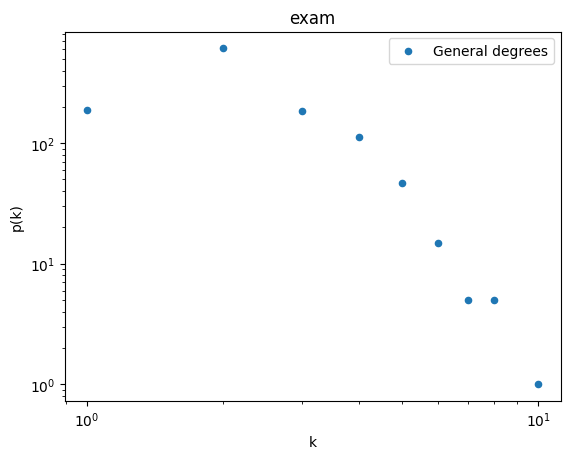

<Figure size 640x480 with 0 Axes>

In [21]:
G = read_pajek("network.net")
G = nx.Graph(nx.convert_node_labels_to_integers(G))
G.name = 'exam'
info(G)

In [26]:
g = G.copy()
for i in range(15):
    node, value = sorted(list(nx.betweenness_centrality(g).items()),key=lambda x: x[1],reverse=True)[0]
    print(g.nodes[node]['label'], end=", ")
    g.remove_node(node)
print([len(x) for x in list(nx.connected_components(g))][0]/len(g))

Brest, Warsaw, Saint Petersburg, Kiev, Niš, Gdańsk, Mukachevo, Chişinău, Trieste, Vinnytsia, Budapest, Zagreb, Oradea, Kherson, Suceava, 0.03364969801553063
